<a href="https://colab.research.google.com/github/yohanesnuwara/volve-machine-learning/blob/main/notebook/volve_p_sonic_prediction_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0. Import libraries and git clone

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
!git clone https://github.com/yohanesnuwara/volve-machine-learning

Cloning into 'volve-machine-learning'...
remote: Enumerating objects: 118, done.
remote: Total 118 (delta 0), reused 0 (delta 0), pack-reused 118
Receiving objects: 100% (118/118), 16.05 MiB | 20.57 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
!pip install lasio
import lasio

## Step 1. Load and Display the Well-log Datasets

In [1]:
import glob
import os

# get all paths and alphabetically ordered
paths = sorted(glob.glob(os.path.join("/content/volve-machine-learning/well_logs", "*.LAS")))

well_df = [0] * 5

for i in range(len(paths)):
  # read with lasio
  well = lasio.read(paths[i])

  # convert to dataframe
  df = well.df()

  # in this dataframe, depth is positioned as index, not as column
  # so better to change depth index to column
  well_df[i] = df.reset_index()

well1, well2, well3, well4, well5 = well_df


In [2]:
well5

0

Well 1, 3, and 4 are the train data. Well 2 and 5 are the test data.

In [3]:
# Display train well data
well = well1 # train wells: well1, well3, well4

# define what logs are we going to us
logs = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']

# create the subplots; ncols equals the number of logs
fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(20,10))

# looping each log to display in the subplots

colors = ['black', 'red', 'blue', 'green', 'purple', 'black', 'orange']

for i in range(len(logs)):
  if i == 3:
    # for resistivity, semilog plot
    ax[i].semilogx(well[logs[i]], well['DEPTH'], color=colors[i])
  else:
    # for non-resistivity, normal plot
    ax[i].plot(well[logs[i]], well['DEPTH'], color=colors[i])
  
  ax[i].set_title(logs[i])
  ax[i].grid(True)

ax[2].set_xlim(0, 300)
plt.tight_layout(1.1)
plt.show()

NameError: ignored

In [ ]:
well.head()

In [ ]:
# Display the test data
well = well2 # test wells: well2, well5

# define what logs are we going to us
logs = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']

# create the subplots; ncols equals the number of logs
fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(13,10))

# looping each log to display in the subplots

colors = ['black', 'red', 'blue', 'green', 'purple', 'black']

for i in range(len(logs)):
  if i == 3:
    # for resistivity, semilog plot
    ax[i].semilogx(well[logs[i]], well['DEPTH'], color=colors[i])
  else:
    # for non-resistivity, normal plot
    ax[i].plot(well[logs[i]], well['DEPTH'], color=colors[i])
  
  ax[i].set_title(logs[i])
  ax[i].grid(True)

ax[2].set_xlim(0, 200)
plt.tight_layout(1)
plt.show()

In [ ]:
well2.head()

## Step 2. Data Preparation

Restrict the NaN values by giving the lower and upper limit of the depth

For training:
* well1: 2,600-3,720 m
* well3: 2,620-3,640 m
* well4: 3,100-3,400 m

For prediction:
* well2: 3,200-4,740 m
* well5: 3,100-4,050 m

After that, drop all unwanted columns.

In [ ]:
# lower limit
low = [2600, 3200, 2620, 3100, 3100]

# upper limit
up = [3720, 4740, 3640, 3400, 4050]

# train columns to use
train_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']

# test columns to use
test_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']

well_df_restrict = [0] * 5

for i in range(len(well_df)):
  # restrict depth within the given lower and upper limit
  df = well_df[i].loc[(well_df[i]['DEPTH'] >= low[i]) & (well_df[i]['DEPTH'] <= up[i])]

  if i == 0 or i == 2 or i == 3:
    # the train data, drop unwanted columns
    well_df_restrict[i] = df[train_cols]
  
  else:
    # the test data, drop unwanted columns
    well_df_restrict[i] = df[test_cols]

well1, well2, well3, well4, well5 = well_df_restrict

# as we can see, both ends already not have NaNs
well2

DEPTH   NPHI   RHOB      GR     RT    PEF   CALI
30115  3200.0  0.075  2.605   9.348  8.331  7.451  8.547
30116  3200.1  0.077  2.602   9.362  8.289  7.464  8.547
30117  3200.2  0.078  2.599   9.545  8.247  7.405  8.547
30118  3200.3  0.079  2.594  11.153  8.206  7.292  8.547
30119  3200.4  0.078  2.589  12.592  8.165  7.167  8.547
...       ...    ...    ...     ...    ...    ...    ...
45511  4739.6  0.104  2.587  34.653  4.532  4.472  8.703
45512  4739.7  0.104  2.594  33.640  4.356  4.634  8.703
45513  4739.8  0.103  2.592  32.217  4.232  4.729  8.734
45514  4739.9  0.108  2.583  29.841  4.233  4.705  8.750
45515  4740.0  0.114  2.571  31.423  4.225  4.617  8.760

[15401 rows x 7 columns]

Check for NaNs

In [ ]:
# check if NaNs exist, for each well
well1.isnull().sum()

DEPTH    0
NPHI     0
RHOB     0
GR       0
RT       0
PEF      0
CALI     0
DT       0
dtype: int64

Merge datasets into 2 single dataframes for training and test. Then, assign well names

Please note: for the sake of next workflows, the unwanted column location must be changed to the right. 

In [ ]:
# merge dataframes
well_train = pd.concat([well1, well3, well4])
well_pred = pd.concat([well2, well5])

# assign names
names = ['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C']

names_train = []
names_pred = []
for i in range(len(well_df_restrict)):
  if i == 0 or i == 2 or i == 3:
    # train data, assign names 
    _ = np.full(len(well_df_restrict[i]), names[i])
    names_train.append(_)
  else:
    # test data, assign names
    _ = np.full(len(well_df_restrict[i]), names[i])
    names_pred.append(_)

# concatenate inside list
import itertools

names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# include well names to the train and pred dataframe
well_train['WELL'] = names_train
well_pred['WELL'] = names_pred

# move the depth column to the right
depth_train, depth_pred = well_train.pop('DEPTH'), well_pred.pop('DEPTH')
well_train['DEPTH'], well_pred['DEPTH'] = depth_train, depth_pred

well_pred

NPHI    RHOB        GR      RT     PEF    CALI        WELL   DEPTH
30115  0.0750  2.6050    9.3480  8.3310  7.4510  8.5470  15_9-F-11B  3200.0
30116  0.0770  2.6020    9.3620  8.2890  7.4640  8.5470  15_9-F-11B  3200.1
30117  0.0780  2.5990    9.5450  8.2470  7.4050  8.5470  15_9-F-11B  3200.2
30118  0.0790  2.5940   11.1530  8.2060  7.2920  8.5470  15_9-F-11B  3200.3
30119  0.0780  2.5890   12.5920  8.1650  7.1670  8.5470  15_9-F-11B  3200.4
...       ...     ...       ...     ...     ...     ...         ...     ...
39037  0.3107  2.4184  106.7613  2.6950  6.2332  8.5569   15_9-F-1C  4049.6
39038  0.2997  2.4186  109.0336  2.6197  6.2539  8.5569   15_9-F-1C  4049.7
39039  0.2930  2.4232  106.0935  2.5948  6.2883  8.5570   15_9-F-1C  4049.8
39040  0.2892  2.4285  105.4931  2.6344  6.3400  8.6056   15_9-F-1C  4049.9
39041  0.2956  2.4309  109.8965  2.6459  6.3998  8.5569   15_9-F-1C  4050.0

[24902 rows x 8 columns]

**bold text**## Step 3. Exploratory Data Analysis

Make pair-plot of the training dataset

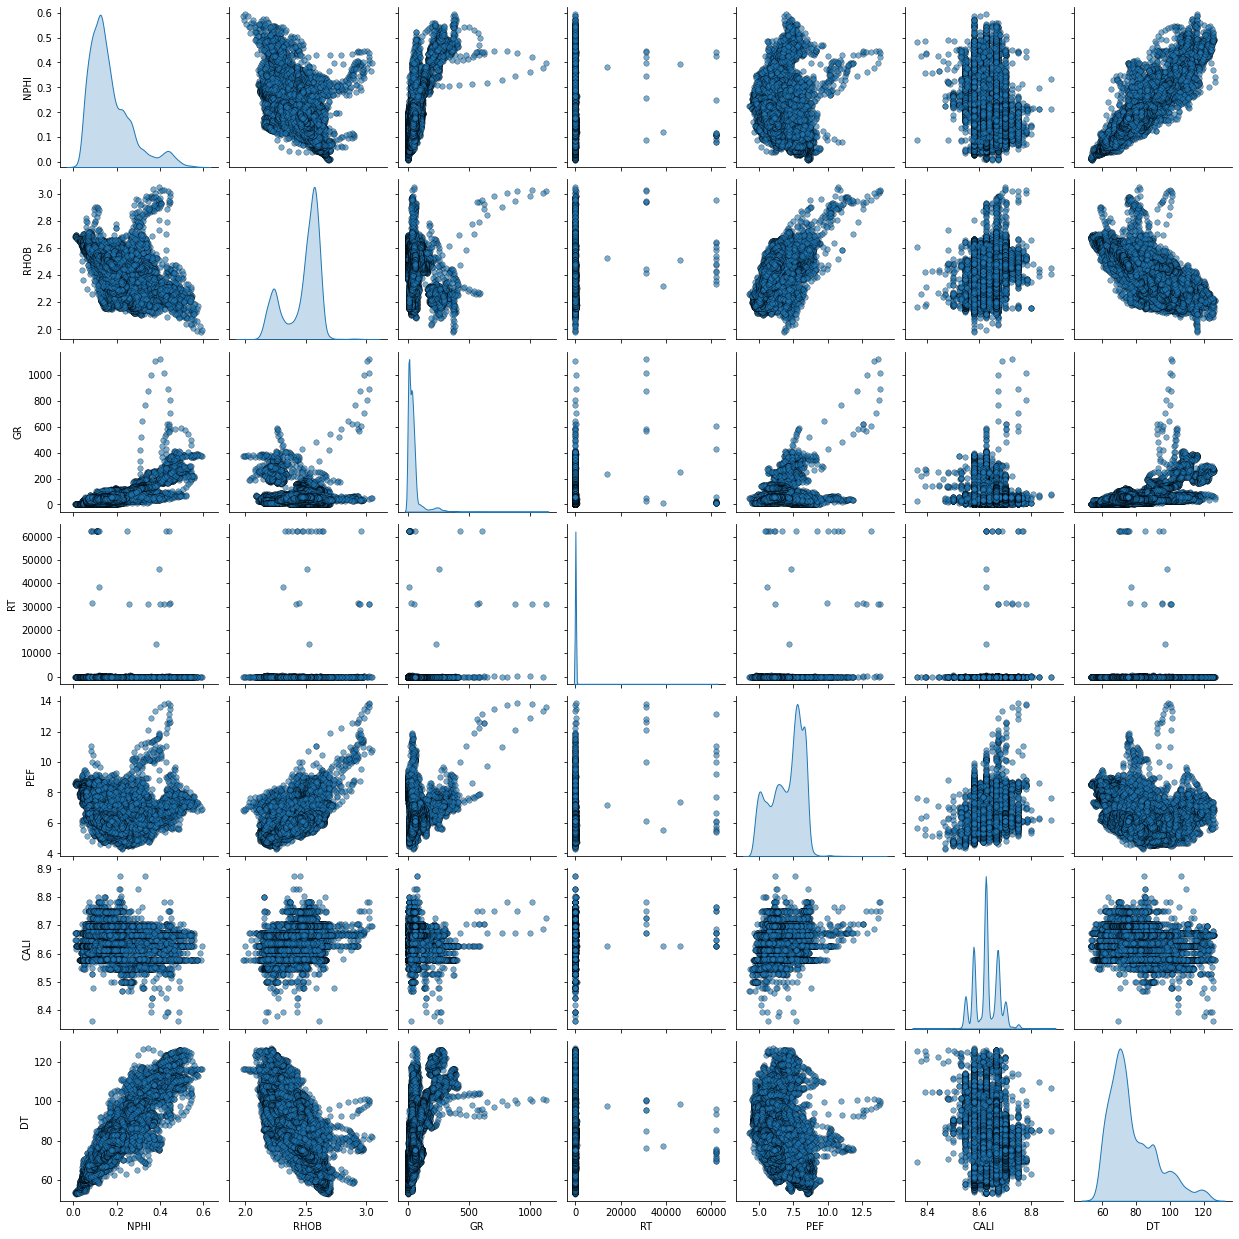

In [ ]:
train_features = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']

sns.pairplot(well_train, vars=train_features, diag_kind='kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

Spearman's correlation heatmap

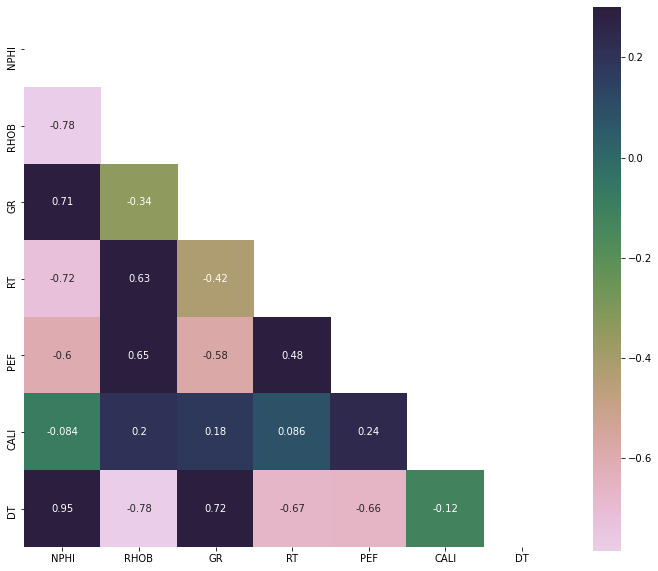

In [ ]:
well_train_only_features = well_train[train_features]

# Generate a mask for the upper triangle
mask = np.zeros_like(well_train_only_features.corr(method = 'spearman') , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.cubehelix_palette(n_colors=12, start=-2.25, rot=-1.3, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(12,10))
sns.heatmap(well_train_only_features.corr(method = 'spearman') ,annot=True,  mask=mask, cmap=cmap, vmax=.3, square=True)

plt.show()

## Step 4. Normalization

Normalize the dataset:
* Log transform the RT log
* Use power transform with Yeo-Johnson method

Please note: we only transform the data except 'WELL' and 'DEPTH' column. We do this using Scikit-Learn's ColumnTransformer. [Reference](https://stackoverflow.com/questions/38420847/apply-standardscaler-to-parts-of-a-data-set)

In [ ]:
colnames = well_train.columns
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = 'DT' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'WELL', 'DEPTH'], dtype='object')

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

# transform the RT to logarithmic
well_train['RT'] = np.log10(well_train['RT'])

# normalize using power transform Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

## ColumnTransformer
column_drop = ['WELL', 'DEPTH']
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

## fit and transform
well_train_norm = ct.fit_transform(well_train)

## convert to dataframe
well_train_norm = pd.DataFrame(well_train_norm, columns=colnames)
well_train_norm

NPHI      RHOB        GR  ...         DT        WELL   DEPTH
0       1.70217 -0.920748   1.13065  ...    1.58838  15_9-F-11A    2600
1        1.5734  -1.02062   1.09243  ...    1.56235  15_9-F-11A  2600.1
2       1.40711  -1.14249   1.03031  ...    1.52506  15_9-F-11A  2600.2
3       1.26069  -1.26308  0.956135  ...    1.46093  15_9-F-11A  2600.3
4       1.18987  -1.36797  0.837247  ...    1.36743  15_9-F-11A  2600.4
...         ...       ...       ...  ...        ...         ...     ...
24398  0.462363 -0.279351  0.839177  ...  0.0479411   15_9-F-1B  3399.6
24399  0.439808 -0.261621  0.860577  ...   0.043466   15_9-F-1B  3399.7
24400  0.393869 -0.232335  0.849885  ...  0.0425913   15_9-F-1B  3399.8
24401  0.373838 -0.176628   0.82264  ...  0.0445959   15_9-F-1B  3399.9
24402  0.351335 -0.106609  0.806807  ...  0.0522922   15_9-F-1B    3400

[24403 rows x 9 columns]

Up until this step, if we pass df.dtypes, we can see all the results are object. So, we change the dtypes to solve this.

In [ ]:
x = well_train_norm[feature_target].astype(float)
y = well_train_norm['WELL'].astype(str)
z = well_train_norm['DEPTH'].astype(float)

well_train_norm = pd.concat([x, y, z], axis=1)

Make pair-plot of data after normalization

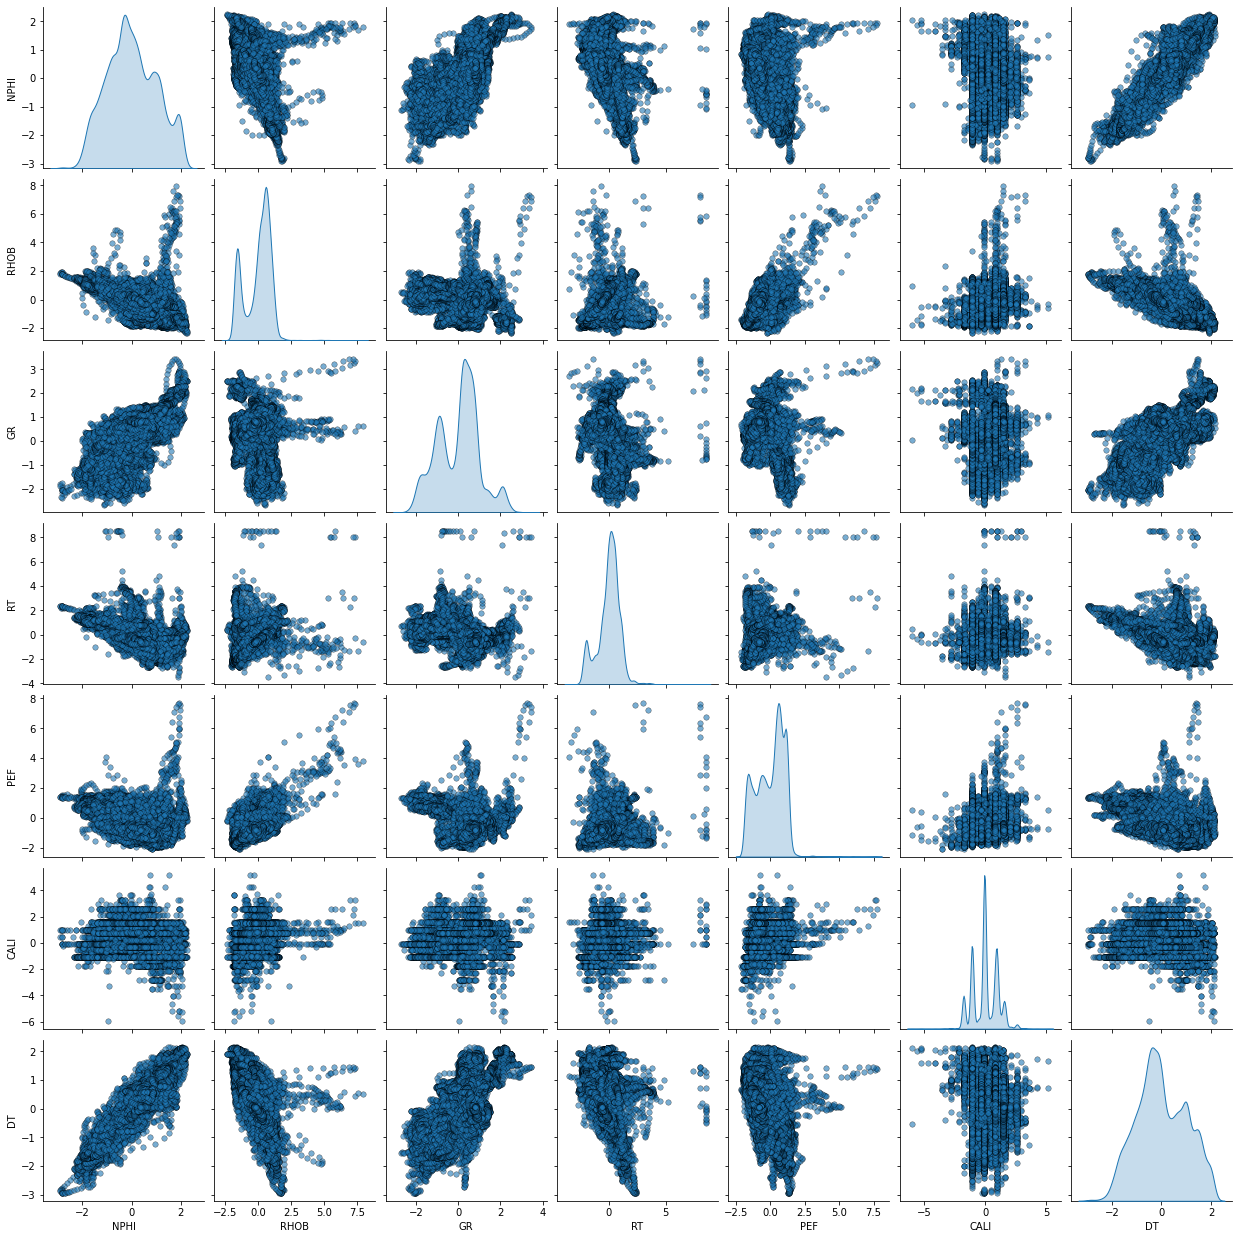

In [ ]:
# x = well_train_norm[feature_target].astype(float)
sns.pairplot(well_train_norm, vars=feature_target, diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

## Step 5. Removing Outliers

In [ ]:
# make copy of well_train_norm, called well_train_dropped
well_train_drop = well_train_norm.copy()

# on the well_train_drop, drop WELL and DEPTH column
well_train_drop = well_train_norm.drop(['WELL', 'DEPTH'], axis=1)

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Method 1: Standard Deviation Method (traditional)
well_train_std = well_train_drop[np.abs(well_train_drop - well_train_drop.mean()) <= (3 * well_train_drop.std())]

## delete all rows that have NaNs
well_train_std = well_train_std.dropna()

# Method 2: Isolation Forest
iso = IsolationForest(contamination=0.5)
yhat = iso.fit_predict(well_train_drop)
mask = yhat != -1
well_train_iso = well_train_norm[mask]

# Method 3: Minimum Covariance Determinant
ee = EllipticEnvelope(contamination=0.1)
yhat = ee.fit_predict(well_train_drop)
mask = yhat != -1
well_train_ee = well_train_norm[mask]

# Method 4: Local Outlier Factor
lof = LocalOutlierFactor(contamination=0.3)
yhat = lof.fit_predict(well_train_drop)
mask = yhat != -1
well_train_lof = well_train_norm[mask]

# Method 5: One-class SVM
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(well_train_drop)
mask = yhat != -1
well_train_svm = well_train_norm[mask]

Number of points before outliers removed                       : 24403
Number of points after outliers removed with Standard Deviation: 24101
Number of points after outliers removed with Isolation Forest  : 12202
Number of points after outliers removed with Min. Covariance   : 21962
Number of points after outliers removed with Outlier Factor    : 17082
Number of points after outliers removed with One-class SVM     : 21964


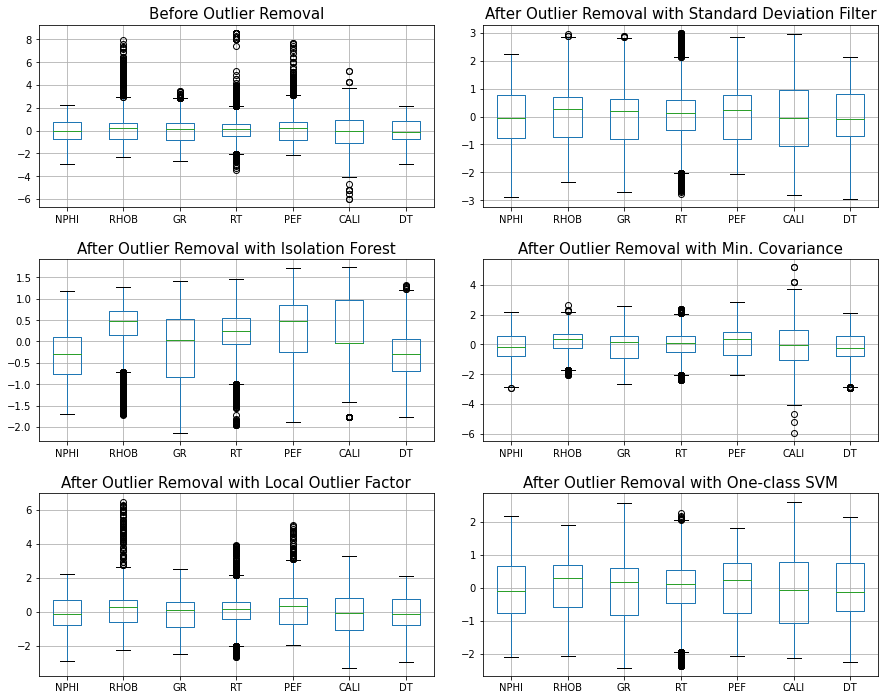

In [ ]:
print('Number of points before outliers removed                       :', len(well_train_norm))
print('Number of points after outliers removed with Standard Deviation:', len(well_train_std))
print('Number of points after outliers removed with Isolation Forest  :', len(well_train_iso))
print('Number of points after outliers removed with Min. Covariance   :', len(well_train_ee))
print('Number of points after outliers removed with Outlier Factor    :', len(well_train_lof))
print('Number of points after outliers removed with One-class SVM     :', len(well_train_svm))

plt.figure(figsize=(13,10))

plt.subplot(3,2,1)
well_train_norm[feature_target].boxplot()
plt.title('Before Outlier Removal', size=15)

plt.subplot(3,2,2)
well_train_std[feature_target].boxplot()
plt.title('After Outlier Removal with Standard Deviation Filter', size=15)

plt.subplot(3,2,3)
well_train_iso[feature_target].boxplot()
plt.title('After Outlier Removal with Isolation Forest', size=15)

plt.subplot(3,2,4)
well_train_ee[feature_target].boxplot()
plt.title('After Outlier Removal with Min. Covariance', size=15)

plt.subplot(3,2,5)
well_train_lof[feature_target].boxplot()
plt.title('After Outlier Removal with Local Outlier Factor', size=15)

plt.subplot(3,2,6)
well_train_svm[feature_target].boxplot()
plt.title('After Outlier Removal with One-class SVM', size=15)

plt.tight_layout(1.7)
plt.show()

We choose the best method: One-class SVM. Make pair-plot of data after outliers removed. 

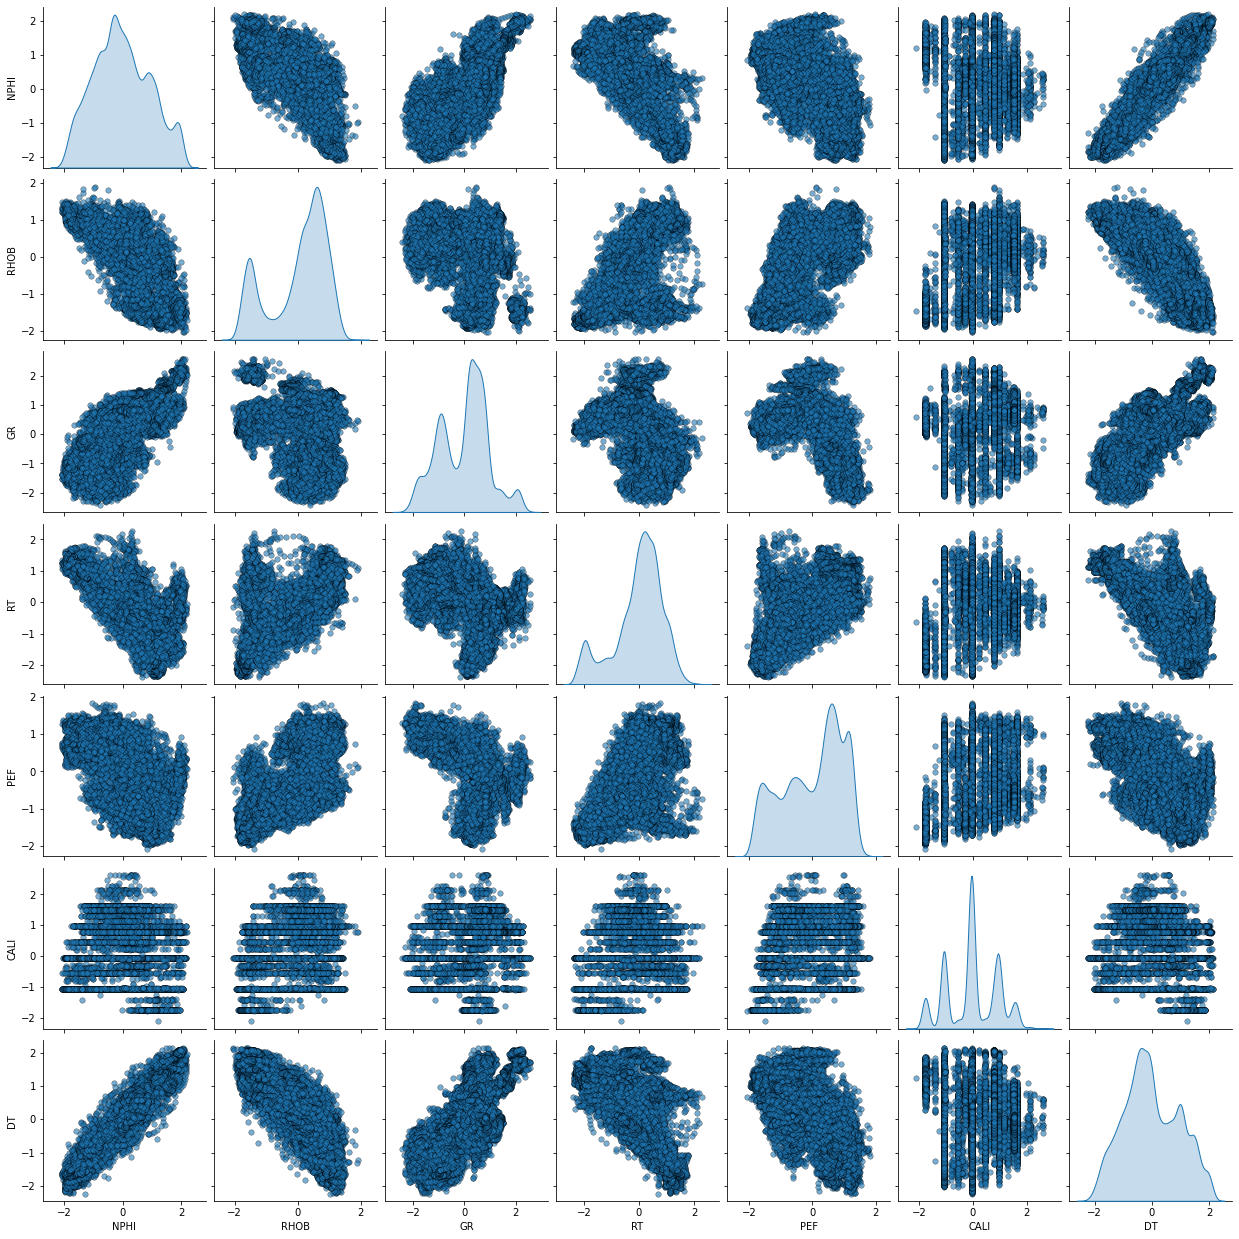

In [ ]:
sns.pairplot(well_train_svm, vars=feature_target,
             diag_kind='kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'})

## Step 5. Prediction! First Attempt

Define the train data as the SVM outlier-removed-data 

In [ ]:
# Define the train data
feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
target = 'DT'

X_train = well_train_svm[only_feature].values
y_train = well_train_svm[only_target].values

In [ ]:
well_train_svm

NPHI      RHOB        GR  ...        DT        WELL   DEPTH
0      1.702168 -0.920748  1.130650  ...  1.588380  15_9-F-11A  2600.0
1      1.573404 -1.020621  1.092435  ...  1.562349  15_9-F-11A  2600.1
2      1.407108 -1.142493  1.030314  ...  1.525055  15_9-F-11A  2600.2
3      1.260691 -1.263078  0.956135  ...  1.460934  15_9-F-11A  2600.3
6      1.196481 -1.480908  0.579649  ...  1.243336  15_9-F-11A  2600.6
...         ...       ...       ...  ...       ...         ...     ...
24398  0.462363 -0.279351  0.839177  ...  0.047941   15_9-F-1B  3399.6
24399  0.439808 -0.261621  0.860577  ...  0.043466   15_9-F-1B  3399.7
24400  0.393869 -0.232335  0.849885  ...  0.042591   15_9-F-1B  3399.8
24401  0.373838 -0.176628  0.822640  ...  0.044596   15_9-F-1B  3399.9
24402  0.351335 -0.106609  0.806807  ...  0.052292   15_9-F-1B  3400.0

[21964 rows x 9 columns]

Define the test data as the copy of normalized data (before outlier-removed)

In [ ]:
# Define the test data 
well_pred1 = well_train_norm.copy()

names_train = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

X_test = []

y_test = []
for i in range(len(names_train)):
  # split the df with respect to its name
  test = well_pred1.loc[well_pred1['WELL'] == names_train[i]]

  # Drop well name column 
  test = test.drop(['WELL'], axis=1)

  # define X_test (feature) and y_test (target)
  X_test_, y_test_ = test[only_feature].values, test[only_target].values
  
  X_test.append(X_test_)
  y_test.append(y_test_)

# for each well 1, 3, and 4
X_test1, X_test3, X_test4 = X_test
y_test1, y_test3, y_test4 = y_test

In [ ]:
X_test1

array([[ 1.70216805, -0.92074812,  1.13064995, -0.63187607,  0.03108323,
         0.45001899],
       [ 1.57340361, -1.02062067,  1.09243495, -0.73615442, -0.3733254 ,
        -1.07084842],
       [ 1.40710799, -1.14249265,  1.03031402, -0.75808007, -0.81989013,
        -1.07084842],
       ...,
       [ 0.92638691,  0.63321138,  1.12953196, -0.55921384, -0.01264487,
         2.94988158],
       [ 0.76485131,  0.39647774,  1.19955805, -0.61185364, -0.116736  ,
         3.26205825],
       [ 0.84349585,  0.19710654,  1.21740147, -0.64915017, -0.14772715,
         3.26205825]])

Fit regression models to train data and predict to test data

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

# Create the regressor
model = GradientBoostingRegressor()
# print(model)

# Fit the regressor to the training data
model.fit(X_train, y_train)

# Predict on well 1
y_pred1 = model.predict(X_test1)
print("R-squared of Well 1: {}".format(model.score(X_test1, y_test1)))
rmse = np.sqrt(mean_squared_error(y_test1, y_pred1))
print("RMSE of Well 1: {}".format(rmse))

# Predict on well 3
y_pred3 = model.predict(X_test3)
print("R-squared of Well 3: {}".format(model.score(X_test3, y_test3)))
rmse = np.sqrt(mean_squared_error(y_test3, y_pred3))
print("RMSE of Well 3: {}".format(rmse))

# Predict on well 4
y_pred4 = model.predict(X_test4)
print("R-squared of Well 4: {}".format(model.score(X_test4, y_test4)))
rmse = np.sqrt(mean_squared_error(y_test4, y_pred4))
print("RMSE of Well 4: {}".format(rmse))

R-squared of Well 1: 0.952616060381417
RMSE of Well 1: 0.2338213984198477
R-squared of Well 3: 0.9428537952826863
RMSE of Well 3: 0.22108422121047183
R-squared of Well 4: 0.8958472187281333
RMSE of Well 4: 0.2459145945424915


Denormalize the output

In [ ]:
# make the transformer fit to the target
y = well_train[target].values
scaler.fit(y.reshape(-1,1))

# denormalize y_test, y_pred
y_test1, y_pred1 = scaler.inverse_transform(y_test1.reshape(-1,1)), scaler.inverse_transform(y_pred1.reshape(-1,1))
y_test3, y_pred3 = scaler.inverse_transform(y_test3.reshape(-1,1)), scaler.inverse_transform(y_pred3.reshape(-1,1))
y_test4, y_pred4 = scaler.inverse_transform(y_test4.reshape(-1,1)), scaler.inverse_transform(y_pred4.reshape(-1,1))

Compare the predicted DT with the true DT

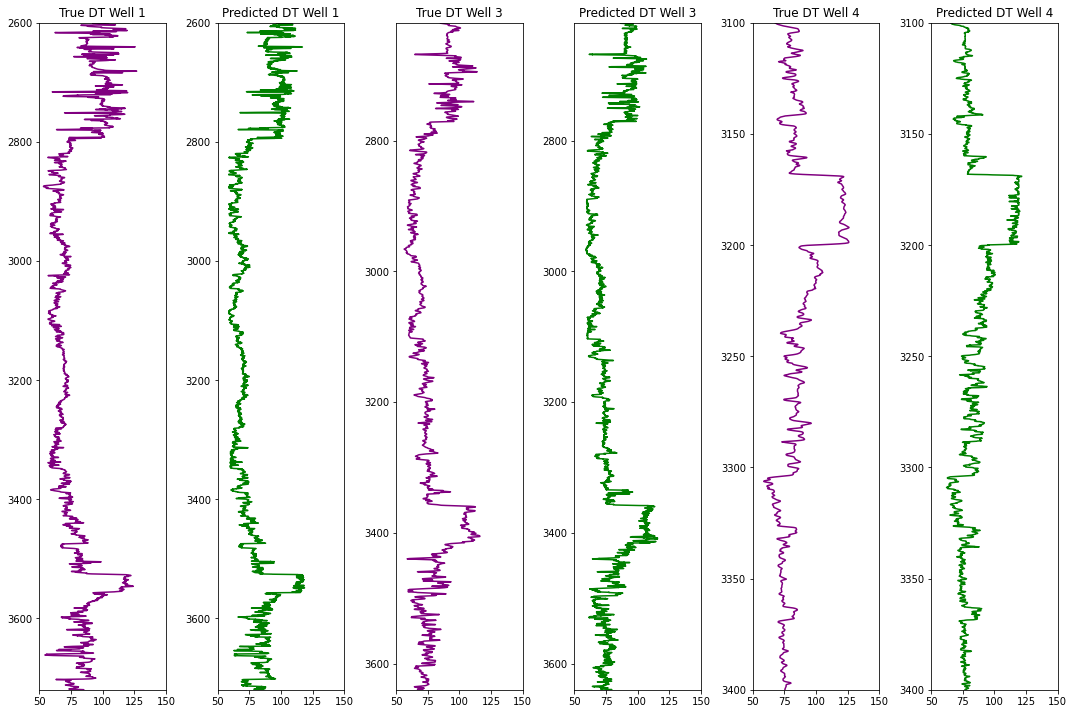

In [ ]:
x = [y_test1, y_pred1, y_test3, y_pred3, y_test4, y_pred4]
y = [well1['DEPTH'], well1['DEPTH'], well3['DEPTH'], well3['DEPTH'], well4['DEPTH'], well4['DEPTH']]

color = ['purple', 'green', 'purple', 'green', 'purple', 'green']
title = ['True DT Well 1', 'Predicted DT Well 1', 'True DT Well 3', 'Predicted DT Well 3',
         'True DT Well 4', 'Predicted DT Well 4']

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,10))

for i in range(len(x)):
  ax[i].plot(x[i], y[i], color=color[i])
  ax[i].set_xlim(50, 150)
  ax[i].set_ylim(np.max(y[i]), np.min(y[i]))
  ax[i].set_title(title[i])

plt.tight_layout(1)

plt.show()

## Step 6. Hyperparameter Tuning

This example below is hyperparameter tuning on Gradient Boosting model, resulting n_estimators 1,000 and max_depth 10.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

# Define the X and y from the SVM normalized dataset
X = well_train_svm[only_feature].values
y = well_train_svm[only_target].values

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = GradientBoostingRegressor()

## Hyperparameters
max_depth = [10, 100]
# max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 4]
min_samples_split = [2, 10]
n_estimators = [100, 1000]

param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth}

## Randomized CV
model_random = GridSearchCV(model, param_grid, cv=3)
model_random.fit(X_train, y_train)

## print best model
model_random.best_params_

{'max_depth': 10, 'n_estimators': 1000}

## Step 7. Use the Tuned Gradient Boosting for Final Prediction

In [ ]:
# Define X_train and y_train
X_train = well_train[only_feature].values
# y_train = well_train[only_target].values.reshape(-1,1)
y_train = well_train[only_target].values

In [ ]:
# Define the test data 
names_train = ['15_9-F-11B', '15_9-F-1C']

X_test = []
y_test = []
depths = []
for i in range(len(names_train)):
  # split the df with respect to its name
  test = well_pred.loc[well_pred['WELL'] == names_train[i]]

  # Drop well name column 
  test = test.drop(['WELL'], axis=1)

  # define X_test (feature)
  X_test_ = test[only_feature].values

  # define depth
  depth_ = test['DEPTH'].values
  
  X_test.append(X_test_)
  depths.append(depth_)

# for each well 2 and 5
X_test2, X_test5 = X_test
depth2, depth5 = depths

In [ ]:
# Normalize X_test of well 2 and 5
X_test2 = scaler.fit_transform(X_test2)
X_test5 = scaler.fit_transform(X_test5)

# Predict to well 2 and 5
y_pred2 = model.predict(X_test2)
y_pred5 = model.predict(X_test5)

# Denormalize y_pred of well 2 and 5
# make the transformer fit to the target
y = well_train[target].values
scaler.fit(y.reshape(-1,1))

# denormalize y_test, y_pred
y_pred2 = scaler.inverse_transform(y_pred2.reshape(-1,1))
y_pred5 = scaler.inverse_transform(y_pred5.reshape(-1,1))

NotFittedError: ignored

In [ ]:
plt.figure(figsize=(5,12))

plt.subplot(1,2,1)
plt.plot(y_pred2, depth2, color='green')
plt.ylim(max(depth2), min(depth2))
plt.title('Predicted DT Well 2', size=12)

plt.subplot(1,2,2)
plt.plot(y_pred5, depth5, color='green')
plt.ylim(max(depth5), min(depth5))
plt.title('Predicted DT Well 5', size=12)

plt.tight_layout(1)
plt.show()

Import the predicted result to the original dataset and write to CSV file. 

In [ ]:
well2['DT'] = y_pred2
well5['DT'] = y_pred5

well2

In [ ]:
# Display the test data
well = well2 # test wells: well2, well5

# define what logs are we going to us
logs = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']

# titles to show
title = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'Predicted DT']

# create the subplots; ncols equals the number of logs
fig, ax = plt.subplots(nrows=1, ncols=len(logs), figsize=(15,10))
fig.suptitle('Well 15/9-F-11B', size=20, y=1.05)

# looping each log to display in the subplots

colors = ['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'green']

for i in range(len(logs)):
  if i == 3:
    # for resistivity, semilog plot
    ax[i].semilogx(well[logs[i]], well['DEPTH'], color=colors[i])
  else:
    # for non-resistivity, normal plot
    ax[i].plot(well[logs[i]], well['DEPTH'], color=colors[i])
  
  ax[i].set_ylim(max(well['DEPTH']), min(well['DEPTH']))
  ax[i].set_title(title[i], pad=15)
  ax[i].grid(True)

ax[2].set_xlim(0, 200)
plt.tight_layout(1)
plt.show()

In [ ]:
well2.to_csv('/content/15_9-F-11B_Predicted_DT.csv', index=False)
well5.to_csv('/content/15_9-F-1C_Predicted_DT.csv', index=False)

In [ ]:
well_train_svm